In [49]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from IPython.display import Image, display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import os

sns.set_style('darkgrid')

MASTER_FILE = os.path.join( '..', 'data', 'training_set.csv' )
RAW_DATA_DIR = os.path.join( '..', 'data', 'train' )
RESULTS_DIR = os.path.join( 'results' )
MODEL_PATH = os.path.join(RESULTS_DIR, 'best_model.h5')

## PARAMS
IMAGE_SIZE = 224

Load master data:

In [46]:
master_data = pd.read_csv(MASTER_FILE, index_col=0)

def look_file_label( file_name ):
    query_data = master_data[ master_data['file'] == file_name ]
    maps = {'N': 'Normal', 'P': 'Pneumonia', 'T': 'Tubercolosis'}
    return maps[ query_data['label'].iloc[0] ]

## 01. Model Loading/Definition:

In [37]:
CLASS_NAMES = np.array(['Normal', 'Pneumonia', 'Tuberculosis'])

def build_cnn_model( n_head_layers, num_classes=3 ):
    
    # preprocess backbone model
    preprocessing_block = tf.keras.Sequential([
        layers.Flatten(),
        layers.BatchNormalization()
    ], name='ConvProcessing')
    
    # define a classification head
    head_layers = []
    for i in range(n_head_layers):
        head_block = tf.keras.Sequential([
            layers.Dense(2**(6 + i), activation='relu'),
            layers.Dropout(0.5),
            layers.BatchNormalization(),
        ])
        head_layers.append( head_block )
    head_layers = head_layers[::-1]
    head_layers.append( layers.Dense( num_classes ) )
    classification_head = tf.keras.Sequential(head_layers, name='ClassHead')
    
    # build the model
    input_image = layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], name='InputLayer')
    x = layers.Lambda( keras.applications.densenet.preprocess_input, name='Preprocessing')(input_image)
    
    x = keras.applications.DenseNet121(
        input_tensor=x,
        include_top=False,
        weights='imagenet'
    ).output
    x = preprocessing_block(x)
    output_label = classification_head(x)
    
    return tf.keras.Model(inputs=[input_image], outputs=[output_label], name='DenseNetBackbone')

def load_cnn_model(model_path):
    return keras.models.load_model(model_path, custom_objects={'macro_f1': None})

final_model = load_cnn_model(MODEL_PATH)

## 02. GradCAM model:

In [36]:
def load_image( image_path, img_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """ Loads a random image for the patient"""
    img = tf.io.read_file( image_path )
    img = tf.io.decode_image( img, channels=3, expand_animations=False )
    img = tf.image.resize( img, img_size )
    return img

def make_gradcam_heatmap(img, pred_index=None):

    # we connect the conv layers to image input
    conv_output = final_model.get_layer('relu')
    grad_model = tf.keras.models.Model(
        [final_model.inputs], [ conv_output.output, final_model.output]
    )

    # get the gradients in the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(tf.expand_dims(img, axis=0))
    
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # get gradient vectors
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # compute the heatmap from the activations
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_index

def get_image_gradcam(image, heatmap, alpha=0.4):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use RGB values of the colormap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# Get the gradcam from the request image:

Helper function:

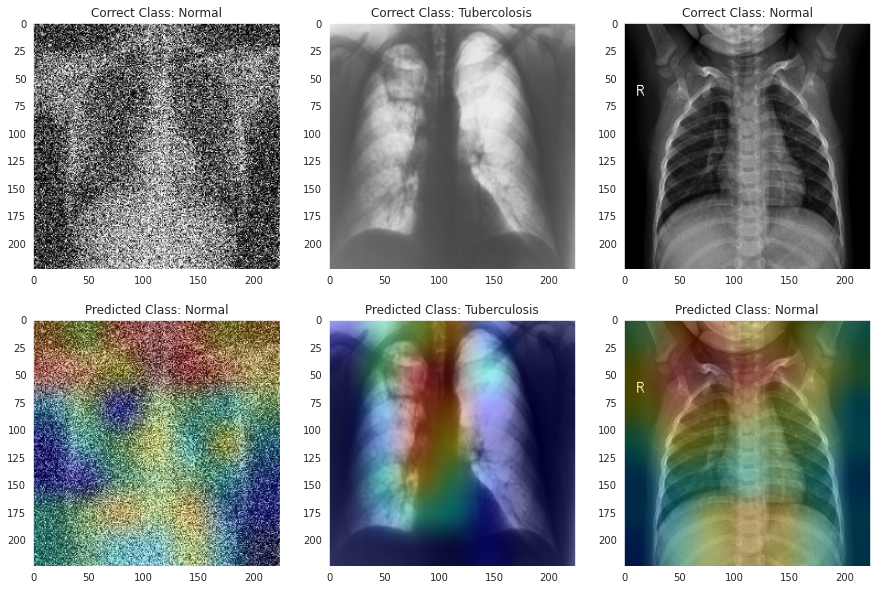

In [51]:

def get_random_images(sample_size, base_dir=RAW_DATA_DIR):
    names = np.random.choice( list( os.listdir( base_dir ) ), size=sample_size)

    fig, ax = plt.subplots(2, sample_size, figsize=(5 * sample_size, 10))
    for i, name in enumerate(names):
        current_image = load_image( os.path.join(base_dir, name) )
        heatmap, pred = make_gradcam_heatmap(current_image, pred_index=None)
        gradcam_image = get_image_gradcam(current_image, heatmap, alpha=0.4)

        ax[0, i].imshow(current_image / 255 )
        ax[0, i].set_title(f"Correct Class: {look_file_label( name )}")
        ax[1, i].set_title(f"Predicted Class: {CLASS_NAMES[pred]}")
        ax[1, i].imshow( gradcam_image )
        
        ax[0, i].grid(False)
        ax[1, i].grid(False)


get_random_images(sample_size=3)